# Observation / Action Specification (Clean Implementation)

TODO:
- [x] Observation Spec `replay_df`
   - [x] Champs
      - [x] Verified
   - [x] Minions
      - [x] Verified
   - [x] Turrets
      - [x] Verified
   - [x] Monsters
      - [x] Verified
   - [x] Missiles
      - [x] Verified
   - [x] Verification (Pre-Scaled)
      - [x] Correct, this is just straight from the SQL statement
   - [x] Verification (Post-Norm)
      - [x] Manual inspection, this is fine, the scaling clearly follows (per-column) the same relative patterns
- [x] Action Spec `replay_df`:
   - [x] Movement
      - [x] Verification
   - [-] Recall (Code available)
   - [x] Spell
     - [x] Q
        - [x] Verify
     - [x] W
        - [x] Verify
     - [x] E (Get direction in digits)
        - [x] Verify
     - [x] D (Flash)
     - [-] F (Ignore this for now)
   - [x] Auto Attack
        - [x] Verify (Looks dodgy asf. Gonna keep for now and hopefully just replace with activespell in future)
- [x] Normalisation and Embedding
   - [x] Normalise numeric values (Min-Max, what type of norm to use here?)
   - [x] Convert strings into embeddings
      - [x] Straight up encode all known string lists
      - [-] Hash open-ended lists (spell name, etc.) and then encode using the hash list
         - [x] Opted for prescence based lists (using idx of present missiles. \
               This should be fine regardless. For the real scale up version of this, \
               will have to use the complete data dragon list regardless.)
- [x] Data Verification

## Populate Game Object Dataframes

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

db_replays_dir = "/Users/joe/Downloads/DB"
db_replays = os.listdir(db_replays_dir)

In [2]:
with open("list_of_champs.txt") as f:
    CHAMP_LIST = f.read().split("\n")

In [3]:
import sqlite3
import pandas as pd
import os
replay_idx = 1
db_replay = os.path.join(db_replays_dir, db_replays[replay_idx])
con = sqlite3.connect(db_replay)

In [4]:
SUMMONER_NAMES = ["SummonerBarrier", "SummonerBoost", "SummonerDot", "SummonerExhaust", "SummonerFlash", "SummonerHaste", "SummonerHeal", "SummonerMana", "SummonerTeleport", "SummonerSmite"]
MINION_NAMES = ['SRU_ChaosMinionMelee', 'SRU_OrderMinionMelee',
       'SRU_ChaosMinionRanged', 'SRU_OrderMinionRanged',
       'SRU_Plant_Vision', 'SRU_OrderMinionSiege', 'SRU_ChaosMinionSiege',
       'TestCubeRender']

In [5]:
AUTO_ATTACK_TARGETS = ["CHAMPS", "TURRETS", "MINIONS", "MISSILES", "MONSTERS", "OTHER"]

In [6]:
GAME_OBJECT_LIST = ["champs", "turrets", "minions", "missiles", "monsters"]

In [7]:
MAX_OBJS = [10, 30, 30, 30, 30]

In [8]:
df_s = {
    obj:pd.read_sql(f"SELECT * FROM {obj};", con).drop(labels=["game_id"], axis=1) for obj in GAME_OBJECT_LIST}

In [9]:
for obj in GAME_OBJECT_LIST:
    print(obj, df_s[obj].columns, df_s[obj].columns.shape)

champs Index(['time', 'name', 'hp', 'max_hp', 'mana', 'max_mana', 'armor', 'mr', 'ad',
       'ap', 'level', 'atk_range', 'visible', 'team', 'pos_x', 'pos_z',
       'q_name', 'q_cd', 'w_name', 'w_cd', 'e_name', 'e_cd', 'r_name', 'r_cd',
       'd_name', 'd_cd', 'f_name', 'f_cd'],
      dtype='object') (28,)
turrets Index(['time', 'name', 'hp', 'max_hp', 'mana', 'max_mana', 'armor', 'mr', 'ad',
       'ap', 'level', 'atk_range', 'visible', 'team', 'pos_x', 'pos_z'],
      dtype='object') (16,)
minions Index(['time', 'name', 'hp', 'max_hp', 'mana', 'max_mana', 'armor', 'mr', 'ad',
       'ap', 'level', 'atk_range', 'visible', 'team', 'pos_x', 'pos_z'],
      dtype='object') (16,)
missiles Index(['time', 'name', 'missile_name', 'spell_name', 'src_idx', 'dst_idx',
       'start_pos_x', 'start_pos_z', 'end_pos_x', 'end_pos_z', 'pos_x',
       'pos_z'],
      dtype='object') (12,)
monsters Index(['time', 'name', 'hp', 'max_hp', 'mana', 'max_mana', 'armor', 'mr', 'ad',
       'ap', 'level', 

In [10]:
df_s["champs"]

,time,name,hp,max_hp,mana,max_mana,armor,mr,ad,ap,...,w_name,w_cd,e_name,e_cd,r_name,r_cd,d_name,d_cd,f_name,f_cd
0,1.001389,Darius,652.00000,652.000,263.00000,263.000,51.000,32.0000,69.400000,0.0,...,DariusNoxianTacticsONH,-1.001389,DariusAxeGrabCone,-1.001389,DariusExecute,-1.001389,SummonerFlash,14.309915,SummonerHaste,14.309915
1,1.001389,MasterYi,669.00000,669.000,251.00000,251.000,45.000,32.0000,70.400000,0.0,...,Meditate,-1.001389,WujuStyle,-1.001389,Highlander,-1.001389,SummonerFlash,14.309915,SummonerSmite,14.309915
2,1.001389,Lissandra,620.00000,620.000,475.00000,475.000,22.000,46.0000,55.000000,18.0,...,LissandraW,-1.001389,LissandraE,-1.001389,LissandraR,-1.001389,SummonerDot,14.309915,SummonerFlash,14.309915
3,1.001389,Ezreal,600.00000,600.000,375.00000,375.000,36.000,30.0000,67.400000,0.0,...,EzrealW,-1.001389,EzrealE,-1.001389,EzrealR,-1.001389,SummonerExhaust,14.309915,SummonerFlash,14.309915
4,1.001389,Renata,545.00000,545.000,350.00000,350.000,39.000,30.0000,49.000000,9.0,...,RenataW,-1.001389,RenataE,-1.001389,RenataR,-1.001389,SummonerDot,14.309915,SummonerFlash,14.309915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6685,179.943250,Jayce,818.95520,856.775,284.55862,466.375,41.375,31.9175,84.068750,0.0,...,JayceHyperCharge,-159.712220,JayceAccelerationGate,-2.280670,JayceStanceGtH,-153.712220,SummonerFlash,-163.943250,SummonerTeleport,-163.943250
6686,179.943250,JarvanIV,622.92035,714.880,308.43408,339.600,51.456,33.4760,71.560005,0.0,...,JarvanIVGoldenAegis,-178.943250,JarvanIVDemacianStandard,1.606583,JarvanIVCataclysm,-178.943250,SummonerSmite,5.436829,SummonerFlash,212.521800
6687,179.943250,Swain,780.28000,780.280,429.73760,488.880,29.744,46.9360,59.944000,36.0,...,SwainW,22.000000,SwainE,-13.072311,SwainR,-178.943250,SummonerHaste,170.034350,SummonerFlash,-163.943250
6688,179.943250,Caitlyn,680.00000,680.000,315.00000,315.000,39.000,30.0000,75.400000,0.0,...,CaitlynW,-178.943250,CaitlynE,-27.936325,CaitlynR,-178.943250,SummonerFlash,220.512190,SummonerHeal,175.470260


## Dataframe Preprocessing

### Clean `missiles_df`

In [11]:
df_s["missiles"] = df_s["missiles"].drop(labels=["name", "src_idx", "dst_idx"], axis=1)

### Convert Champ Names into Index

In [12]:
df_s["champs"] = df_s["champs"][df_s["champs"]["name"].astype(bool)]

In [13]:
df_s["champs"]["name"].unique()

array(['Darius', 'MasterYi', 'Lissandra', 'Ezreal', 'Renata', 'Jayce',
       'JarvanIV', 'Swain', 'Caitlyn', 'Karma', 'Turret'], dtype=object)

In [14]:
df_s["champs"]["name"] = df_s["champs"]["name"].apply(lambda d: CHAMP_LIST.index(d))

In [15]:
df_s["champs"]["d_name"] = df_s["champs"]["d_name"].apply(lambda d: SUMMONER_NAMES.index(d))
df_s["champs"]["f_name"] = df_s["champs"]["f_name"].apply(lambda d: SUMMONER_NAMES.index(d))

### Convert Champ Spells into Index

In [16]:
# Full champ spells list which needs to be feature hashed
SPELL_NAMES = \
    df_s["champs"].q_name.unique().tolist() + \
    df_s["champs"].w_name.unique().tolist() + \
    df_s["champs"].e_name.unique().tolist() + \
    df_s["champs"].r_name.unique().tolist()

df_s["champs"]["q_name"] = df_s["champs"]["q_name"].apply(lambda d: SPELL_NAMES.index(d))
df_s["champs"]["w_name"] = df_s["champs"]["w_name"].apply(lambda d: SPELL_NAMES.index(d))
df_s["champs"]["e_name"] = df_s["champs"]["e_name"].apply(lambda d: SPELL_NAMES.index(d))
df_s["champs"]["r_name"] = df_s["champs"]["r_name"].apply(lambda d: SPELL_NAMES.index(d))

### Convert Missile Names and Missile Spell Names into Index

In [17]:
# Full champ spells list which needs to be feature hashed
MISSILE_NAMES = \
    df_s["missiles"].missile_name.unique().tolist()
MISSILE_SPELL_NAMES = df_s["missiles"].spell_name.unique().tolist()

df_s["missiles"]["missile_name"] = df_s["missiles"]["missile_name"].apply(lambda d: MISSILE_NAMES.index(d))
df_s["missiles"]["spell_name"] = df_s["missiles"]["spell_name"].apply(lambda d: MISSILE_SPELL_NAMES.index(d))

### Convert Minion and Turret Names into Index

In [18]:
MINION_NAMES   = list(df_s["minions"].name.unique())
TURRET_NAMES   = list(df_s["turrets"].name.unique())
MONSTER_NAMES  = list(df_s["monsters"].name.unique())

df_s["minions"]["name"]  = df_s["minions"]["name"].apply(lambda d: MINION_NAMES.index(d))
df_s["turrets"]["name"]  = df_s["turrets"]["name"].apply(lambda d: TURRET_NAMES.index(d))
df_s["monsters"]["name"] = df_s["monsters"]["name"].apply(lambda d: MONSTER_NAMES.index(d))

In [19]:
df_s["missiles"].head()

,time,missile_name,spell_name,start_pos_x,start_pos_z,end_pos_x,end_pos_z,pos_x,pos_z
0,37.762760,0,0,1.159747e+04,6.419603e+03,1.155958e+04,6.588502e+03,1.159485e+04,6.546899e+03
1,38.049454,0,0,1.159747e+04,6.419603e+03,1.155958e+04,6.588502e+03,1.161661e+04,6.658827e+03
2,38.318043,0,1,4.960000e-43,4.960000e-43,1.054195e-27,1.055360e-27,4.960000e-43,4.960000e-43
3,38.585052,0,1,4.960000e-43,4.960000e-43,1.055360e-27,1.090190e-27,4.960000e-43,4.960000e-43
4,38.918830,0,1,4.960000e-43,4.960000e-43,1.055360e-27,1.090190e-27,4.960000e-43,4.960000e-43


### Data Cleaning for all Game Object Dataframes

In [20]:
for obj in GAME_OBJECT_LIST:
    if obj != "missiles":
        df_s[obj] = df_s[obj].drop_duplicates(
            subset=["time", "name"])
    else:
        df_s[obj] = df_s[obj].drop_duplicates(
            subset=["time", "missile_name"])
    df_s[obj] = df_s[obj][
        df_s[obj]["time"] > 15]

### Data Normalisation for Champs DF

In [21]:
df_s["champs"].loc[df_s["champs"]['q_cd'] < 0, 'q_cd'] = 0
df_s["champs"].loc[df_s["champs"]['w_cd'] < 0, 'w_cd'] = 0
df_s["champs"].loc[df_s["champs"]['e_cd'] < 0, 'e_cd'] = 0
df_s["champs"].loc[df_s["champs"]['r_cd'] < 0, 'r_cd'] = 0
df_s["champs"].loc[df_s["champs"]['d_cd'] < 0, 'd_cd'] = 0
df_s["champs"].loc[df_s["champs"]['f_cd'] < 0, 'f_cd'] = 0

## Data Verification

#### Plot Champs

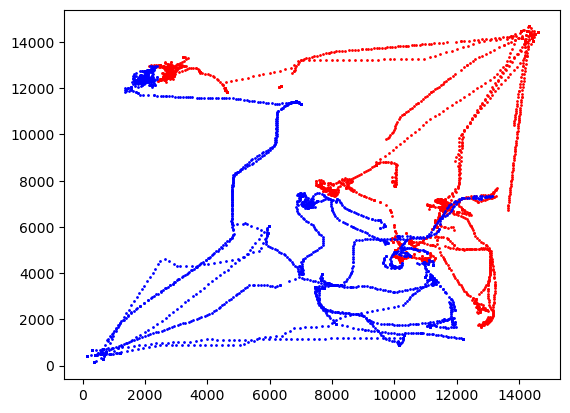

In [22]:
import matplotlib.pyplot as plt
for team in [200, 100]:
    c = "blue" if team == 100 else "red"
    champs_positions_df = pd.read_sql(f"SELECT pos_x, pos_z FROM champs WHERE pos_x < 16000 AND pos_z < 16000 AND team={team};", con)
    champs_positions_x_s = champs_positions_df["pos_x"]
    champs_positions_y_s = champs_positions_df["pos_z"]
    plt.scatter(champs_positions_x_s, champs_positions_y_s, s=1, c=c)

#### Plot Towers

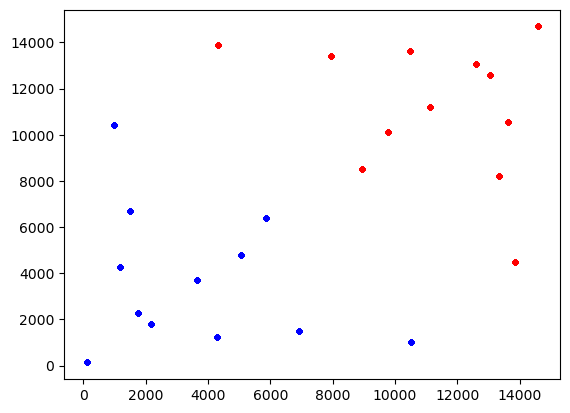

In [23]:
import matplotlib.pyplot as plt
for team in [200, 100]:
    c = "blue" if team == 100 else "red"
    tower_positions_df = pd.read_sql(f"SELECT pos_x, pos_z FROM turrets WHERE pos_x < 16000 AND pos_z < 16000 AND team={team};", con)
    tower_positions_x_s = tower_positions_df["pos_x"]
    tower_positions_y_s = tower_positions_df["pos_z"]
    plt.scatter(tower_positions_x_s, tower_positions_y_s, s=10, c=c)

#### Plot Minions

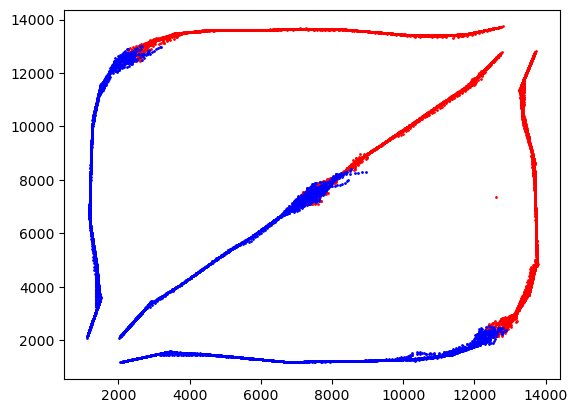

In [24]:
import matplotlib.pyplot as plt
for team in [200, 100]:
    c = "blue" if team == 100 else "red"
    minion_positions_df = pd.read_sql(f"SELECT pos_x, pos_z FROM minions WHERE pos_x < 16000 AND pos_z < 16000 AND team={team};", con)
    minion_positions_df = minion_positions_df.drop_duplicates(subset=["pos_x", "pos_z"])
    minion_positions_x_s = minion_positions_df["pos_x"]
    minion_positions_y_s = minion_positions_df["pos_z"]
    plt.scatter(minion_positions_x_s, minion_positions_y_s, s=1, c=c)

#### Plot Monsters

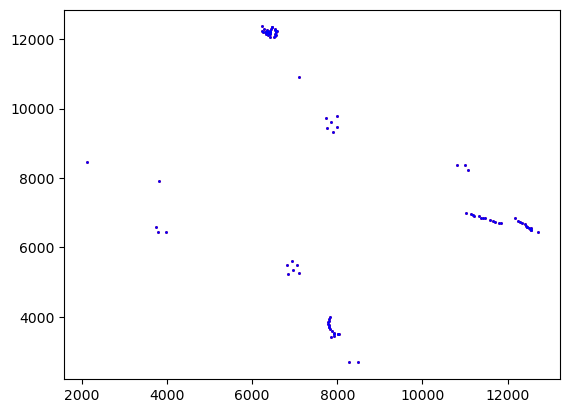

In [25]:
import matplotlib.pyplot as plt
for team in [200, 100]:
    c = "blue" if team == 100 else "red"
    monsters_positions_df = pd.read_sql(f"SELECT pos_x, pos_z FROM monsters WHERE pos_x < 16000 AND pos_z < 16000;", con)
    monsters_positions_df = monsters_positions_df.drop_duplicates(subset=["pos_x", "pos_z"])
    monsters_positions_x_s = monsters_positions_df["pos_x"]
    monsters_positions_y_s = monsters_positions_df["pos_z"]
    plt.scatter(monsters_positions_x_s, monsters_positions_y_s, s=1, c=c)

#### Plot Missiles

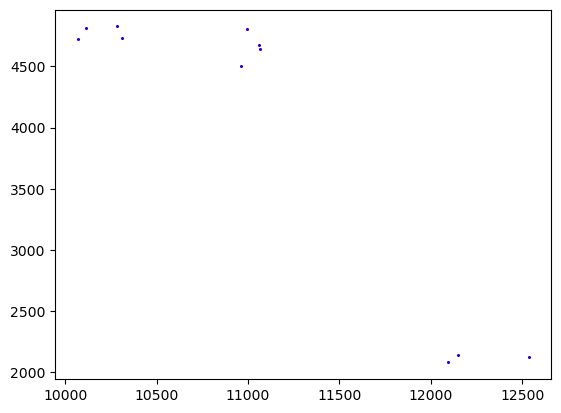

In [26]:
import matplotlib.pyplot as plt
for team in [200, 100]:
    c = "blue" if team == 100 else "red"
    missiles_positions_df = pd.read_sql(f"SELECT pos_x, pos_z FROM missiles WHERE pos_x < 16000 AND pos_z < 16000 AND name LIKE 'EzrealBasic%';", con)
    missiles_positions_df = missiles_positions_df.drop_duplicates(subset=["pos_x", "pos_z"])
    missiles_positions_x_s = missiles_positions_df["pos_x"]
    missiles_positions_y_s = missiles_positions_df["pos_z"]
    plt.scatter(missiles_positions_x_s, missiles_positions_y_s, s=1, c=c)

## Observation Spec

### Init `replay_df`

In [27]:
replay_df = pd.DataFrame()
times = df_s["champs"].drop_duplicates(subset=['time'])["time"]
replay_df["time"] = times

### Add Distance Between Local Player and All Game Objects

In [28]:
player_df = df_s["champs"][df_s["champs"]["name"] == CHAMP_LIST.index("Ezreal")]

In [29]:
def add_distances(original_df):
    # Step 1: Filter out Player's data
    player_df_data = player_df[['time', 'pos_x', 'pos_z']]

    # Step 2: Merge with the original DataFrame on 'time'
    merged_df = original_df.merge(player_df_data, on='time', suffixes=('', '_player'))

    # Step 3: Calculate Euclidean distance
    merged_df['distance_from_player_x'] = abs(
        merged_df["pos_x_player"] - merged_df["pos_x"])
    merged_df['distance_from_player_z'] = abs(
        merged_df["pos_z_player"] - merged_df["pos_z"])
    merged_df['distance_from_player'] = np.sqrt(
        (merged_df['pos_x'] - merged_df['pos_x_player'])**2 +
        (merged_df['pos_z'] - merged_df['pos_z_player'])**2)
    merged_df = merged_df.drop(columns=["pos_x_player", "pos_z_player"])
    
    return merged_df

for obj in GAME_OBJECT_LIST:
    df_s[obj] = add_distances(df_s[obj])

### Min-Max Scale All Non-String Columns

In [30]:
champ_pos    = df_s["champs"].drop_duplicates(subset=["time", "pos_x", "pos_z"])
turrets_pos  = df_s["turrets"].drop_duplicates(subset=["time", "pos_x", "pos_z"])
monsters_pos = df_s["monsters"].drop_duplicates(subset=["time", "pos_x", "pos_z"])
minions_pos  = df_s["minions"].drop_duplicates(subset=["time", "pos_x", "pos_z"])

In [31]:
champ_pos

,time,name,hp,max_hp,mana,max_mana,armor,mr,ad,ap,...,e_cd,r_name,r_cd,d_name,d_cd,f_name,f_cd,distance_from_player_x,distance_from_player_z,distance_from_player
0,15.16182,23,762.00000,762.000,263.00000,263.000,51.000,32.0000,69.400000,0.0,...,0.000000,37,0.0,4,0.838180,5,0.83818,8.0000,90.000,90.354856
1,15.16182,78,669.00000,669.000,251.00000,251.000,45.000,32.0000,70.400000,0.0,...,0.000000,38,0.0,4,0.838180,9,0.83818,144.0000,78.000,163.768129
2,15.16182,71,710.00000,710.000,475.00000,475.000,22.000,46.0000,55.000000,36.0,...,0.000000,39,0.0,2,0.838180,4,0.83818,232.0000,386.000,450.355415
3,15.16182,30,700.00000,700.000,375.00000,375.000,36.000,30.0000,77.400000,0.0,...,0.000000,40,0.0,3,0.838180,4,0.83818,0.0000,0.000,0.000000
4,15.16182,104,570.00000,570.000,350.00000,350.000,39.000,30.0000,49.000000,19.0,...,0.000000,41,0.0,2,0.838180,4,0.83818,64.0000,178.000,189.156020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5895,179.94325,50,818.95520,856.775,284.55862,466.375,41.375,31.9175,84.068750,0.0,...,0.000000,48,0.0,4,0.000000,8,0.00000,1998.6921,12791.357,12946.566495
5896,179.94325,48,622.92035,714.880,308.43408,339.600,51.456,33.4760,71.560005,0.0,...,1.606583,43,0.0,9,5.436829,4,212.52180,5098.0000,11520.000,12597.618981
5897,179.94325,124,780.28000,780.280,429.73760,488.880,29.744,46.9360,59.944000,36.0,...,0.000000,44,0.0,5,170.034350,4,0.00000,8518.5360,9243.520,12570.127986
5898,179.94325,18,680.00000,680.000,315.00000,315.000,39.000,30.0000,75.400000,0.0,...,0.000000,45,0.0,4,220.512190,6,175.47026,12411.4980,6189.277,13869.117938


In [32]:
# Create the scaler instance
champs_scaler   = MinMaxScaler(feature_range=(0, 1))
missiles_scaler = MinMaxScaler(feature_range=(0, 1))
turrets_scaler  = MinMaxScaler(feature_range=(0, 1))
minions_scaler  = MinMaxScaler(feature_range=(0, 1))
monsters_scaler = MinMaxScaler(feature_range=(0, 1))

COLUMNS_TO_SCALE = {
    "champs":   ['time', 'hp', 'max_hp', 'mana', 'max_mana', 'armor', 'mr', 'ad',
       'ap', 'level', 'atk_range', 'visible', 'team', 'pos_x', 'pos_z',
       'q_cd', 'w_cd', 'e_cd', 'r_cd', 'd_cd', 'f_cd', 'distance_from_player_x',
       'distance_from_player_z', 'distance_from_player'],
    "other":  ['time', 'hp', 'max_hp', 'mana', 'max_mana', 'armor', 'mr', 'ad',
       'ap', 'level', 'atk_range', 'visible', 'team', 'pos_x', 'pos_z',
       'distance_from_player_x', 'distance_from_player_z',
       'distance_from_player'],
    "missiles":  ['time', 'start_pos_x', 'start_pos_z',
       'end_pos_x', 'end_pos_z', 'pos_x', 'pos_z', 'distance_from_player_x',
       'distance_from_player_z', 'distance_from_player']
}

for obj in GAME_OBJECT_LIST:
    col_list = obj if obj in COLUMNS_TO_SCALE.keys() else "other"
    cols_to_scale = COLUMNS_TO_SCALE[col_list]  # Columns to be scaled

    # Select columns to scale
    df_to_scale = df_s[obj][cols_to_scale]

    # Determine the appropriate scaler and scale the data
    if obj == "champs":
        scaled_data = champs_scaler.fit_transform(df_to_scale)
    elif obj == "missiles":
        scaled_data = missiles_scaler.fit_transform(df_to_scale)
    elif obj == "turrets":
        scaled_data = turrets_scaler.fit_transform(df_to_scale)
    elif obj == "minions":
        scaled_data = minions_scaler.fit_transform(df_to_scale)
    elif obj == "monsters":
        scaled_data = monsters_scaler.fit_transform(df_to_scale)

    # Replace the original columns in df_s[obj] with the scaled data
    df_s[obj][cols_to_scale] = scaled_data

### Flatten Observations

In [33]:
testdf_s = {}

#### Flatten Each Dataframe

In [34]:
times = df_s["champs"]["time"].unique()

def flatten_obs(df, max_objs, times):
    # print(df.columns)
    new_cols = [f"{c}_{idx}"
                for idx in range(max_objs)
                for c in df.columns[1:]]
    new_cols = ["time"] + new_cols
    obs   = []
    for tm in times:
        cur = df[df["time"] == tm]
        vals = cur.values[:, 1:]
        vals = vals[:max_objs, :]

        if cur.shape[0] < max_objs:
            padding_val = max_objs - vals.shape[0]
            padding = np.zeros((padding_val, vals.shape[1]))
            vals = np.vstack((vals, padding))
    
        # Flatten
        new_vals = np.hstack(vals)

        # Append
        obs.append(new_vals)

    # Combine
    obs   = np.vstack(obs)
    times = np.expand_dims(np.array(times), axis=1)
    obs   = np.hstack((times, obs))
    # print(obs.shape)
    obs_df = pd.DataFrame(data=obs, columns=new_cols)

    return obs_df

for obj, max_objs in zip(GAME_OBJECT_LIST, MAX_OBJS):
    # print("OBJ, MAX:", obj, max_objs)
    testdf_s[obj] = flatten_obs(df_s[obj], max_objs, times)

#### Combine All Flattened Dataframes

In [35]:
times_unsqueeze = np.expand_dims(times, 1)
replay_df_vals = [df.iloc[:, 1:] for df in testdf_s.values()]
replay_df_vals = np.hstack(replay_df_vals)
print(times_unsqueeze.shape, replay_df_vals.shape)
replay_df_vals = np.hstack((times_unsqueeze, replay_df_vals))

(590, 1) (590, 2250)


In [36]:
replay_df_vals.shape

(590, 2251)

In [37]:
def flatten_list(lst):
    return [x for xs in lst for x in xs]

replay_df_cols = [list(testdf_s[k].columns[1:].values) for k in testdf_s.keys()]
replay_df_cols = flatten_list(replay_df_cols)
replay_df_cols = ["time"] + replay_df_cols

In [38]:
replay_df = pd.DataFrame(
    data=replay_df_vals,
    columns=replay_df_cols)
replay_df

,time,name_0,hp_0,max_hp_0,mana_0,max_mana_0,armor_0,mr_0,ad_0,ap_0,...,ap_29,level_29,atk_range_29,visible_29,team_29,pos_x_29,pos_z_29,distance_from_player_x_29,distance_from_player_z_29,distance_from_player_29
0,0.000000,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.001215,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.002836,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.004563,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.006268,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585,0.991974,23.0,0.887174,1.000000,0.313464,0.284195,1.000000,0.280382,0.760371,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
586,0.993632,23.0,0.889506,1.000000,0.315785,0.284195,1.000000,0.280382,0.760371,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
587,0.995508,23.0,0.889506,1.000000,0.315785,0.284195,1.000000,0.280382,0.760371,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
588,0.998437,23.0,0.891825,1.000000,0.318105,0.284195,1.000000,0.280382,0.760371,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
replay_df_save_time = replay_df["time"]
replay_df_save_time

0      0.000000
1      0.001215
2      0.002836
3      0.004563
4      0.006268
         ...   
585    0.991974
586    0.993632
587    0.995508
588    0.998437
589    1.000000
Name: time, Length: 590, dtype: float64

## Action Spec

### Temp: Set `replay_df` time to non-scaled times

In [40]:
replay_df["time"] = player_df["time"].values

### Movement

In [41]:
import math

player_cur_pos  = player_df[["time", "pos_x", "pos_z"]]
player_next_pos = player_df[["time", "pos_x", "pos_z"]].shift(+1)
player_next_pos = player_next_pos.fillna(0)
player_x_delta  = player_cur_pos["pos_x"] - player_next_pos["pos_x"]
player_z_delta  = player_cur_pos["pos_z"] - player_next_pos["pos_z"]
player_x_delta.iloc[0] = 0
player_z_delta.iloc[0] = 0

player_x_delta_digit = (player_x_delta / 100).round().clip(-4, +4)
player_z_delta_digit = (player_z_delta / 100).round().clip(-4, +4)

player_df["player_x_delta"]       = player_x_delta
player_df["player_z_delta"]       = player_z_delta
player_df["player_delta"]         = np.sqrt(player_x_delta ** 2 + player_z_delta ** 2)
player_df["player_x_delta_digit"] = player_x_delta_digit
player_df["player_z_delta_digit"] = player_z_delta_digit

In [42]:
player_movement_df_final = \
    player_df[["time", "player_x_delta_digit", "player_z_delta_digit"]] # , "player_x_delta", "player_z_delta", "pos_x", "pos_z"]]
player_movement_df_final

,time,player_x_delta_digit,player_z_delta_digit
503,15.161820,0.0,0.0
513,15.362079,1.0,-0.0
523,15.629139,2.0,-0.0
533,15.913677,2.0,0.0
543,16.194675,1.0,0.0
...,...,...,...
6643,178.620790,0.0,0.0
6653,178.893860,0.0,0.0
6663,179.203000,0.0,0.0
6673,179.685680,0.0,0.0


#### Visual Verification (Compare Digitised Movements vs Real Continuous Movements)

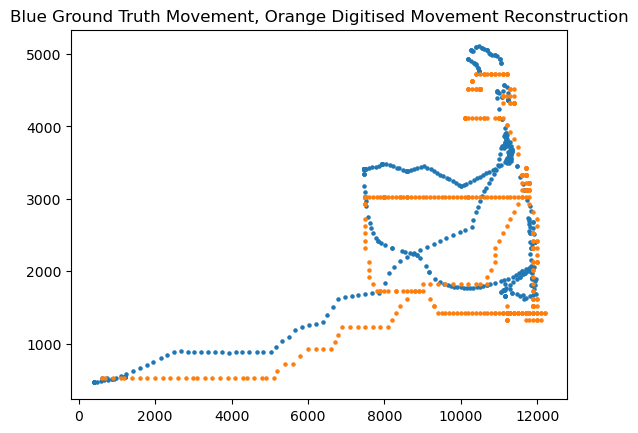

In [43]:
import matplotlib.pyplot as plt

x, y = player_df["pos_x"].iloc[0], player_df["pos_z"].iloc[0]
digit_x_s, digit_z_s = [], []
for cur_x, cur_y in zip(player_movement_df_final["player_x_delta_digit"], player_movement_df_final["player_z_delta_digit"]):
    x += (cur_x) * 100
    y += (cur_y) * 100
    # print(x, y)
    digit_x_s.append(x)
    digit_z_s.append(y)

plt.title("Blue Ground Truth Movement, Orange Digitised Movement Reconstruction")
plt.scatter(player_df["pos_x"], player_df["pos_z"], s=5)
plt.scatter(digit_x_s, digit_z_s, s=5)

In [44]:
replay_df = pd.merge(replay_df, player_movement_df_final, on="time")
replay_df

,time,name_0,hp_0,max_hp_0,mana_0,max_mana_0,armor_0,mr_0,ad_0,ap_0,...,atk_range_29,visible_29,team_29,pos_x_29,pos_z_29,distance_from_player_x_29,distance_from_player_z_29,distance_from_player_29,player_x_delta_digit,player_z_delta_digit
0,15.161820,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,15.362079,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.0
2,15.629139,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,-0.0
3,15.913677,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
4,16.194675,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585,178.620790,23.0,0.887174,1.000000,0.313464,0.284195,1.000000,0.280382,0.760371,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
586,178.893860,23.0,0.889506,1.000000,0.315785,0.284195,1.000000,0.280382,0.760371,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
587,179.203000,23.0,0.889506,1.000000,0.315785,0.284195,1.000000,0.280382,0.760371,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
588,179.685680,23.0,0.891825,1.000000,0.318105,0.284195,1.000000,0.280382,0.760371,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Recall (Not Using this Yet)

In [45]:
still_frames_matches = ((player_df["player_x_delta_digit"] == 0) & \
(player_df["player_z_delta_digit"] == 0))
still_frames_idx = still_frames_matches[still_frames_matches].index
still_frames = player_df.loc[still_frames_idx]

still_frames["time_diff"] = still_frames["time"].diff().fillna(0)
still_frames['consecutive'] = still_frames['time_diff'] < 1

still_frames['group'] = (~still_frames['consecutive']).cumsum()

# Get the start and end times for each group
group_start_end_times = still_frames.groupby('group')['time'].agg(['min', 'max'])

# Calculate the duration of each group
group_start_end_times['duration'] = group_start_end_times['max'] - group_start_end_times['min']

# Find groups where the duration is at least 8 seconds
long_groups = group_start_end_times[group_start_end_times['duration'] >= 8].index

# Extract all rows belonging to these groups
long_duration_groups = still_frames[still_frames['group'].isin(long_groups)]
long_duration_groups

,time,name,hp,max_hp,mana,max_mana,armor,mr,ad,ap,...,f_name,f_cd,player_x_delta,player_z_delta,player_delta,player_x_delta_digit,player_z_delta_digit,time_diff,consecutive,group
1233,34.592770,30,700.00000,700.00,375.0,375.0,36.000000,30.000,77.4,0.0,...,4,0.0,38.512,19.3191,43.085981,0.0,0.0,19.430950,False,1
1243,34.859783,30,700.00000,700.00,375.0,375.0,36.000000,30.000,77.4,0.0,...,4,0.0,41.635,-27.3159,49.795900,0.0,-0.0,0.267013,True,1
1253,35.126800,30,700.00000,700.00,375.0,375.0,36.000000,30.000,77.4,0.0,...,4,0.0,20.041,47.0400,51.131236,0.0,0.0,0.267017,True,1
1263,35.393806,30,700.00000,700.00,375.0,375.0,36.000000,30.000,77.4,0.0,...,4,0.0,15.113,7.0012,16.655917,0.0,0.0,0.267006,True,1
1273,35.660816,30,700.00000,700.00,375.0,375.0,36.000000,30.000,77.4,0.0,...,4,0.0,-4.391,8.0242,9.147058,-0.0,0.0,0.267010,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6433,173.030500,30,258.04153,773.44,425.4,425.4,39.384003,30.936,79.2,0.0,...,4,0.0,0.000,0.0000,0.000000,0.0,0.0,0.302240,True,29
6443,173.323870,30,274.73060,773.44,425.4,425.4,39.384003,30.936,79.2,0.0,...,4,0.0,0.000,0.0000,0.000000,0.0,0.0,0.293370,True,29
6453,173.631930,30,290.97284,773.44,425.4,425.4,39.384003,30.936,79.2,0.0,...,4,0.0,0.000,0.0000,0.000000,0.0,0.0,0.308060,True,29
6463,173.973750,30,323.90414,773.44,425.4,425.4,39.384003,30.936,79.2,0.0,...,4,0.0,0.000,0.0000,0.000000,0.0,0.0,0.341820,True,29


### Spells

In [46]:
def swap_columns(df, col1, col2):
    """
    Swap two columns in a pandas DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame in which to swap columns.
    col1 (str): The name of the first column to swap.
    col2 (str): The name of the second column to swap.
    """
    temp = df[col1].copy()
    df[col1] = df[col2]
    df[col2] = temp
    return df

In [47]:
d_name = player_df["d_name"]
if d_name.iloc[0] != SUMMONER_NAMES.index("SummonerFlash"):
    swap_columns(player_df, "d_name", "f_name")
    swap_columns(player_df, "d_cd", "f_cd")

In [48]:
d_name = player_df["d_name"]
d_name

503     4
513     4
523     4
533     4
543     4
       ..
6643    4
6653    4
6663    4
6673    4
6683    4
Name: d_name, Length: 590, dtype: int64

In [49]:
spell_casts = player_df[["time", "q_cd", "w_cd", "e_cd", "r_cd", "d_cd", "f_cd"]]

#### Q

In [50]:
# Get every time q was cast (this will be 100% acc)
qcd_s_cur  = spell_casts["q_cd"]
qcd_s_prev = spell_casts["q_cd"].shift(+1).fillna(0)
qcd_s_diff = qcd_s_cur - qcd_s_prev
q_cast     = (qcd_s_diff > 4) & (qcd_s_cur > 0)
# spell_casts_full = spell_casts.merge(q_cast, on=["time"])
print("Number of ezreal q casts:", q_cast.sum())

# Look through ezreal missiles to find the ezreal q's
# (This will be less than 100% acc because of timing issue with scraping
# missiles)
ezreal_q_df = pd.read_sql(
    "SELECT time, start_pos_x, start_pos_z, end_pos_x, end_pos_z FROM missiles WHERE spell_name = 'EzrealQ';",
    con)
ezreal_q_df = ezreal_q_df.drop_duplicates(
    subset=['start_pos_x', 'start_pos_z'])
print(ezreal_q_df)

# Get q spell aim as digital
ezreal_q_start_pos  = ezreal_q_df[["time", "start_pos_x", "start_pos_z"]]
ezreal_q_end_pos = ezreal_q_df[["time", "end_pos_x", "end_pos_z"]]
ezreal_q_end_pos = ezreal_q_end_pos.fillna(0)
ezreal_q_x_delta  = ezreal_q_end_pos["end_pos_x"] - ezreal_q_start_pos["start_pos_x"]
ezreal_q_z_delta  = ezreal_q_end_pos["end_pos_z"] - ezreal_q_start_pos["start_pos_z"]

ezreal_q_x_delta_digit = (ezreal_q_x_delta / 100).round().clip(-4, +4)
ezreal_q_z_delta_digit = (ezreal_q_z_delta / 100).round().clip(-4, +4)

ezreal_q_df["ezreal_q_x_delta"] = ezreal_q_x_delta
ezreal_q_df["ezreal_q_z_delta"] = ezreal_q_z_delta
ezreal_q_df["ezreal_q_x_delta_digit"] = ezreal_q_x_delta_digit
ezreal_q_df["ezreal_q_z_delta_digit"] = ezreal_q_z_delta_digit

Number of ezreal q casts: 8
         time  start_pos_x  start_pos_z   end_pos_x  end_pos_z
0   113.85533    11627.154    2008.4045  12786.8880  2312.7397
3   125.41175    11968.105    1685.9860  13138.6210  1945.7842
5   137.89891    11931.261    2375.7540  13128.2920  2307.0706
7   145.60045    10910.239    4319.1206  10451.1045  5426.7290
9   150.95409    11231.975    4363.1560  10225.9320  5015.4434
13  156.87094    10524.350    5081.4814   9326.4560  5029.9756
15  161.00770    10400.368    4851.0234   9683.9500  3889.5945


In [51]:
ezreal_q_df.columns

Index(['time', 'start_pos_x', 'start_pos_z', 'end_pos_x', 'end_pos_z',
       'ezreal_q_x_delta', 'ezreal_q_z_delta', 'ezreal_q_x_delta_digit',
       'ezreal_q_z_delta_digit'],
      dtype='object')

In [52]:
ezreal_q_df_final = \
    ezreal_q_df[["time", "ezreal_q_x_delta_digit", "ezreal_q_z_delta_digit"]]
ezreal_q_df_final["using_q"] = 1
ezreal_q_df_final

/var/folders/zb/zb7f652n559gx4c68jjjxzfh0000gn/T/ipykernel_2710/1335434122.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ezreal_q_df_final["using_q"] = 1


,time,ezreal_q_x_delta_digit,ezreal_q_z_delta_digit,using_q
0,113.85533,4.0,3.0,1
3,125.41175,4.0,3.0,1
5,137.89891,4.0,-1.0,1
7,145.60045,-4.0,4.0,1
9,150.95409,-4.0,4.0,1
13,156.87094,-4.0,-1.0,1
15,161.00770,-4.0,-4.0,1


#### Visual Verification of Ezreal Q's by Comparing Ezreal Position and Missile Lines

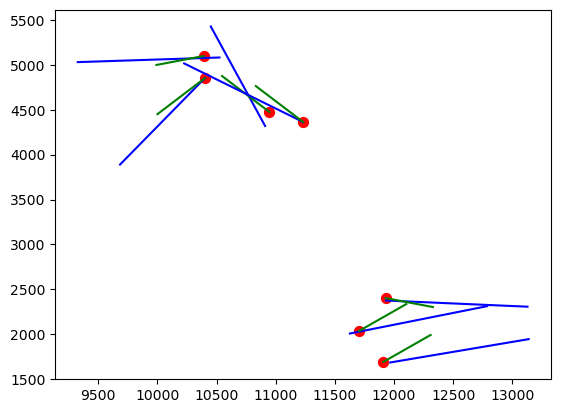

In [53]:
import matplotlib.pyplot as plt

# Assuming you want to plot over the entire range of [0, 16000]
# plt.scatter([0, 16_000], [0, 16_000], s=0)

# Iterate over the rows of the dataframe
for _, row in ezreal_q_df.iterrows():
    tm = row["time"]  # Get the time from the current row
    x  = player_df[player_df["time"] == tm]["pos_x"].iloc[0]  # Use the time to filter the player dataframe
    y  = player_df[player_df["time"] == tm]["pos_z"].iloc[0]  # and get the first matching row
    x1 = row["start_pos_x"]  # Get the starting x position from the current row
    y1 = row["start_pos_z"]  # Get the starting z position from the current row
    x2 = row["end_pos_x"]    # Get the ending x position from the current row
    y2 = row["end_pos_z"]    # Get the ending z position from the current row
    
    digital_x = x
    digital_x += ezreal_q_df_final[ezreal_q_df_final["time"] == tm]["ezreal_q_x_delta_digit"].iloc[0] * 100
    digital_z = y
    digital_z += ezreal_q_df_final[ezreal_q_df_final["time"] == tm]["ezreal_q_z_delta_digit"].iloc[0] * 100
    plt.plot([x1, x2], [y1, y2], color='blue')  # Plot the line for the Ezreal Q
    plt.plot([x, digital_x], [y, digital_z], c="green")
    plt.scatter(x, y, c="red", s=50)  # Plot the player's position

# Set the axes limits if needed
# plt.xlim(0, 16000)
# plt.ylim(0, 16000)

In [54]:
replay_df = pd.merge(replay_df, ezreal_q_df_final, on="time", how="left")

In [55]:
replay_df["using_q"] = replay_df["using_q"].fillna(0)
replay_df = replay_df.fillna(0)
replay_df

,time,name_0,hp_0,max_hp_0,mana_0,max_mana_0,armor_0,mr_0,ad_0,ap_0,...,pos_x_29,pos_z_29,distance_from_player_x_29,distance_from_player_z_29,distance_from_player_29,player_x_delta_digit,player_z_delta_digit,ezreal_q_x_delta_digit,ezreal_q_z_delta_digit,using_q
0,15.161820,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,15.362079,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,-0.0,0.0,0.0,0.0
2,15.629139,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,-0.0,0.0,0.0,0.0
3,15.913677,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
4,16.194675,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585,178.620790,23.0,0.887174,1.000000,0.313464,0.284195,1.000000,0.280382,0.760371,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
586,178.893860,23.0,0.889506,1.000000,0.315785,0.284195,1.000000,0.280382,0.760371,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
587,179.203000,23.0,0.889506,1.000000,0.315785,0.284195,1.000000,0.280382,0.760371,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
588,179.685680,23.0,0.891825,1.000000,0.318105,0.284195,1.000000,0.280382,0.760371,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### W (not verified)

In [56]:
# Get every time w was cast (this will be 100% acc)
wcd_s_cur  = spell_casts["w_cd"]
wcd_s_prev = spell_casts["w_cd"].shift(+1).fillna(0)
wcd_s_diff = wcd_s_cur - wcd_s_prev
w_cast     = (wcd_s_diff > 11) & (wcd_s_cur > 0)
# spell_casts_full = spell_casts.merge(w_cast, on=["time"])
print("Number of ezreal w casts:", w_cast.sum())

# Look through ezreal missiles to find the ezreal w's
# (This will be less than 100% acc because of timing issue with scraping
# missiles)
ezreal_w_df = pd.read_sql(
    "SELECT time, start_pos_x, start_pos_z, end_pos_x, end_pos_z FROM missiles WHERE spell_name = 'EzrealW';",
    con)
ezreal_w_df = ezreal_w_df.drop_duplicates(
    subset=['start_pos_x', 'start_pos_z'])
#ezreal_w_df

# Get w spell aim as digital
ezreal_w_start_pos  = ezreal_w_df[["time", "start_pos_x", "start_pos_z"]]
ezreal_w_end_pos = ezreal_w_df[["time", "end_pos_x", "end_pos_z"]]
ezreal_w_end_pos = ezreal_w_end_pos.fillna(0)
ezreal_w_x_delta  = ezreal_w_end_pos["end_pos_x"] - ezreal_w_start_pos["start_pos_x"]
ezreal_w_z_delta  = ezreal_w_end_pos["end_pos_z"] - ezreal_w_start_pos["start_pos_z"]

ezreal_w_x_delta_digit = (ezreal_w_x_delta / 100).round().clip(-4, +4)
ezreal_w_z_delta_digit = (ezreal_w_z_delta / 100).round().clip(-4, +4)

ezreal_w_df["ezreal_w_x_delta"] = ezreal_w_x_delta
ezreal_w_df["ezreal_w_z_delta"] = ezreal_w_z_delta
ezreal_w_df["ezreal_w_x_delta_digit"] = ezreal_w_x_delta_digit
ezreal_w_df["ezreal_w_z_delta_digit"] = ezreal_w_z_delta_digit

Number of ezreal w casts: 0


In [57]:
ezreal_w_df_final = \
    ezreal_w_df[["time", "ezreal_w_x_delta_digit", "ezreal_w_z_delta_digit"]]
ezreal_w_df_final["using_w"] = 1

In [58]:
replay_df = pd.merge(replay_df, ezreal_w_df_final, on="time", how="left")

In [59]:
replay_df

,time,name_0,hp_0,max_hp_0,mana_0,max_mana_0,armor_0,mr_0,ad_0,ap_0,...,distance_from_player_z_29,distance_from_player_29,player_x_delta_digit,player_z_delta_digit,ezreal_q_x_delta_digit,ezreal_q_z_delta_digit,using_q,ezreal_w_x_delta_digit,ezreal_w_z_delta_digit,using_w
0,15.161820,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
1,15.362079,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,0.0,0.0,1.0,-0.0,0.0,0.0,0.0,NaN,NaN,NaN
2,15.629139,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,0.0,0.0,2.0,-0.0,0.0,0.0,0.0,NaN,NaN,NaN
3,15.913677,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
4,16.194675,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585,178.620790,23.0,0.887174,1.000000,0.313464,0.284195,1.000000,0.280382,0.760371,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
586,178.893860,23.0,0.889506,1.000000,0.315785,0.284195,1.000000,0.280382,0.760371,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
587,179.203000,23.0,0.889506,1.000000,0.315785,0.284195,1.000000,0.280382,0.760371,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
588,179.685680,23.0,0.891825,1.000000,0.318105,0.284195,1.000000,0.280382,0.760371,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN


In [60]:
replay_df["using_w"] = replay_df["using_w"].fillna(0)
replay_df = replay_df.fillna(0)
replay_df

,time,name_0,hp_0,max_hp_0,mana_0,max_mana_0,armor_0,mr_0,ad_0,ap_0,...,distance_from_player_z_29,distance_from_player_29,player_x_delta_digit,player_z_delta_digit,ezreal_q_x_delta_digit,ezreal_q_z_delta_digit,using_q,ezreal_w_x_delta_digit,ezreal_w_z_delta_digit,using_w
0,15.161820,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0
1,15.362079,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,0.0,0.0,1.0,-0.0,0.0,0.0,0.0,0,0,0.0
2,15.629139,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,0.0,0.0,2.0,-0.0,0.0,0.0,0.0,0,0,0.0
3,15.913677,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0,0,0.0
4,16.194675,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585,178.620790,23.0,0.887174,1.000000,0.313464,0.284195,1.000000,0.280382,0.760371,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0
586,178.893860,23.0,0.889506,1.000000,0.315785,0.284195,1.000000,0.280382,0.760371,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0
587,179.203000,23.0,0.889506,1.000000,0.315785,0.284195,1.000000,0.280382,0.760371,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0
588,179.685680,23.0,0.891825,1.000000,0.318105,0.284195,1.000000,0.280382,0.760371,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0


In [61]:
replay_df

,time,name_0,hp_0,max_hp_0,mana_0,max_mana_0,armor_0,mr_0,ad_0,ap_0,...,distance_from_player_z_29,distance_from_player_29,player_x_delta_digit,player_z_delta_digit,ezreal_q_x_delta_digit,ezreal_q_z_delta_digit,using_q,ezreal_w_x_delta_digit,ezreal_w_z_delta_digit,using_w
0,15.161820,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0
1,15.362079,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,0.0,0.0,1.0,-0.0,0.0,0.0,0.0,0,0,0.0
2,15.629139,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,0.0,0.0,2.0,-0.0,0.0,0.0,0.0,0,0,0.0
3,15.913677,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0,0,0.0
4,16.194675,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585,178.620790,23.0,0.887174,1.000000,0.313464,0.284195,1.000000,0.280382,0.760371,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0
586,178.893860,23.0,0.889506,1.000000,0.315785,0.284195,1.000000,0.280382,0.760371,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0
587,179.203000,23.0,0.889506,1.000000,0.315785,0.284195,1.000000,0.280382,0.760371,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0
588,179.685680,23.0,0.891825,1.000000,0.318105,0.284195,1.000000,0.280382,0.760371,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0


#### E

In [62]:
# Get every time e was cast (this will be 100% acc)
ecd_s_cur  = spell_casts["e_cd"]
ecd_s_prev = spell_casts["e_cd"].shift(+1).fillna(0)
ecd_s_diff = ecd_s_cur - ecd_s_prev
e_cast     = (ecd_s_diff > 25) & (ecd_s_cur > 0)
print("Number of ezreal e casts:", e_cast.sum())
e_cast_idx_s = e_cast[e_cast].index

# create a dataframe with all of e cast action params
e_cast_vals = []
e_cast_cols = ["time", "ezreal_e_x_delta_digit", "ezreal_e_z_delta_digit"]
for e_cast_idx in e_cast_idx_s:
    # e_cast_idx = e_cast_idx_s[0]
    e_row = player_df.loc[e_cast_idx-50:e_cast_idx+50][["time", "player_delta"]]
    e_row_idx = e_row.idxmax()["player_delta"]
    tm, x, y = player_df.loc[e_row_idx][["time", "player_x_delta_digit", "player_z_delta_digit"]]
    e_cast_vals.append([tm, x, y])

ezreal_e_df_final = pd.DataFrame(data=e_cast_vals, columns=e_cast_cols)
ezreal_e_df_final["using_e"] = 1
ezreal_e_df_final["using_e"] = ezreal_e_df_final["using_e"].fillna(0)
ezreal_e_df_final = ezreal_e_df_final.fillna(0)
ezreal_e_df_final

Number of ezreal e casts: 1


,time,ezreal_e_x_delta_digit,ezreal_e_z_delta_digit,using_e
0,152.02368,-2.0,4.0,1


#### Visual Verification of Ezreal E's by Comparing After Ezreal Position vs Digital

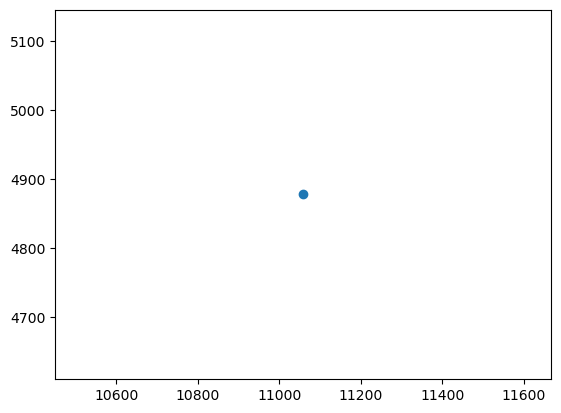

In [63]:
# # x  = player_df[player_df["time"] == tm]["pos_x"].iloc[0]  # Use the time to filter the player dataframe
# tm = ezreal_e_df_final["time"]
# ezreal_x_during_e = player_df[player_df["time"] == tm]["pos_x"].iloc[0]
# ezreal_y_during_e = player_df[player_df["time"] == tm]["pos_z"].iloc[0]
# plt.scatter(ezreal_x_during_e, ezreal_y_during_e)

import matplotlib.pyplot as plt

# Assuming ezreal_e_df_final is a DataFrame with the times you want to plot
for _, row in ezreal_e_df_final.iterrows():
    tm = row["time"]  # Get the current time value from the row
    # Filter player_df for the current time and get the first matching row's position
    ezreal_x_during_e = player_df[player_df["time"] == tm]["pos_x"].iloc[0]
    ezreal_y_during_e = player_df[player_df["time"] == tm]["pos_z"].iloc[0]
    # Plot the position for the current time
    plt.scatter(ezreal_x_during_e, ezreal_y_during_e)

# Show the plot
plt.show()

In [64]:
replay_df = pd.merge(replay_df, ezreal_e_df_final, on="time", how="left")

In [65]:
replay_df

,time,name_0,hp_0,max_hp_0,mana_0,max_mana_0,armor_0,mr_0,ad_0,ap_0,...,player_z_delta_digit,ezreal_q_x_delta_digit,ezreal_q_z_delta_digit,using_q,ezreal_w_x_delta_digit,ezreal_w_z_delta_digit,using_w,ezreal_e_x_delta_digit,ezreal_e_z_delta_digit,using_e
0,15.161820,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,NaN,NaN,NaN
1,15.362079,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,-0.0,0.0,0.0,0.0,0,0,0.0,NaN,NaN,NaN
2,15.629139,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,-0.0,0.0,0.0,0.0,0,0,0.0,NaN,NaN,NaN
3,15.913677,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,NaN,NaN,NaN
4,16.194675,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585,178.620790,23.0,0.887174,1.000000,0.313464,0.284195,1.000000,0.280382,0.760371,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,NaN,NaN,NaN
586,178.893860,23.0,0.889506,1.000000,0.315785,0.284195,1.000000,0.280382,0.760371,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,NaN,NaN,NaN
587,179.203000,23.0,0.889506,1.000000,0.315785,0.284195,1.000000,0.280382,0.760371,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,NaN,NaN,NaN
588,179.685680,23.0,0.891825,1.000000,0.318105,0.284195,1.000000,0.280382,0.760371,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,NaN,NaN,NaN


In [66]:
replay_df["using_e"] = replay_df["using_e"].fillna(0)
replay_df = replay_df.fillna(0)
replay_df

,time,name_0,hp_0,max_hp_0,mana_0,max_mana_0,armor_0,mr_0,ad_0,ap_0,...,player_z_delta_digit,ezreal_q_x_delta_digit,ezreal_q_z_delta_digit,using_q,ezreal_w_x_delta_digit,ezreal_w_z_delta_digit,using_w,ezreal_e_x_delta_digit,ezreal_e_z_delta_digit,using_e
0,15.161820,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0
1,15.362079,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,-0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0
2,15.629139,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,-0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0
3,15.913677,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0
4,16.194675,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585,178.620790,23.0,0.887174,1.000000,0.313464,0.284195,1.000000,0.280382,0.760371,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0
586,178.893860,23.0,0.889506,1.000000,0.315785,0.284195,1.000000,0.280382,0.760371,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0
587,179.203000,23.0,0.889506,1.000000,0.315785,0.284195,1.000000,0.280382,0.760371,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0
588,179.685680,23.0,0.891825,1.000000,0.318105,0.284195,1.000000,0.280382,0.760371,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0


#### Flash

In [67]:
# Get every time e was cast (this will be 100% acc)
dcd_s_cur  = spell_casts["d_cd"]
dcd_s_prev = spell_casts["d_cd"].shift(+1).fillna(0)
dcd_s_diff = dcd_s_cur - dcd_s_prev
d_cast     = (dcd_s_diff > 250) & (dcd_s_cur > 0)
d_cast_idx_s = d_cast[d_cast].index

d_cast_vals = []
d_cast_cols = ["time", "ezreal_d_x_delta_digit", "ezreal_d_z_delta_digit"]
for d_cast_idx in d_cast_idx_s:
    d_row = player_df.loc[d_cast_idx-50:d_cast_idx+50][["time", "player_delta"]]
    d_row_idx = d_row.idxmax()["player_delta"]
    tm, x, y = player_df.loc[d_row_idx][["time", "player_x_delta_digit", "player_z_delta_digit"]]
    d_cast_vals.append([tm, x, y])

ezreal_d_df_final = pd.DataFrame(data=d_cast_vals, columns=d_cast_cols)
ezreal_d_df_final["using_d"] = 1
ezreal_d_df_final

,time,ezreal_d_x_delta_digit,ezreal_d_z_delta_digit,using_d


In [68]:
replay_df = pd.merge(replay_df, ezreal_d_df_final, on="time", how="left")

In [69]:
replay_df

,time,name_0,hp_0,max_hp_0,mana_0,max_mana_0,armor_0,mr_0,ad_0,ap_0,...,using_q,ezreal_w_x_delta_digit,ezreal_w_z_delta_digit,using_w,ezreal_e_x_delta_digit,ezreal_e_z_delta_digit,using_e,ezreal_d_x_delta_digit,ezreal_d_z_delta_digit,using_d
0,15.161820,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
1,15.362079,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2,15.629139,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
3,15.913677,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
4,16.194675,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585,178.620790,23.0,0.887174,1.000000,0.313464,0.284195,1.000000,0.280382,0.760371,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
586,178.893860,23.0,0.889506,1.000000,0.315785,0.284195,1.000000,0.280382,0.760371,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
587,179.203000,23.0,0.889506,1.000000,0.315785,0.284195,1.000000,0.280382,0.760371,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
588,179.685680,23.0,0.891825,1.000000,0.318105,0.284195,1.000000,0.280382,0.760371,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN


In [70]:
replay_df["using_d"] = replay_df["using_d"].fillna(0)
replay_df = replay_df.fillna(0)
replay_df

,time,name_0,hp_0,max_hp_0,mana_0,max_mana_0,armor_0,mr_0,ad_0,ap_0,...,using_q,ezreal_w_x_delta_digit,ezreal_w_z_delta_digit,using_w,ezreal_e_x_delta_digit,ezreal_e_z_delta_digit,using_e,ezreal_d_x_delta_digit,ezreal_d_z_delta_digit,using_d
0,15.161820,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0
1,15.362079,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0
2,15.629139,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0
3,15.913677,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0
4,16.194675,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585,178.620790,23.0,0.887174,1.000000,0.313464,0.284195,1.000000,0.280382,0.760371,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0
586,178.893860,23.0,0.889506,1.000000,0.315785,0.284195,1.000000,0.280382,0.760371,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0
587,179.203000,23.0,0.889506,1.000000,0.315785,0.284195,1.000000,0.280382,0.760371,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0
588,179.685680,23.0,0.891825,1.000000,0.318105,0.284195,1.000000,0.280382,0.760371,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0


#### Alt (Not using this yet)

In [71]:
fcd_s_cur  = spell_casts["f_cd"]
fcd_s_prev = spell_casts["f_cd"].shift(+1).fillna(0)
fcd_s_diff = fcd_s_cur - fcd_s_prev
f_cast     = (fcd_s_diff > 180) & (fcd_s_cur > 0)
f_cast_idx_s = f_cast[f_cast].index
print("Alt sum casts:", f_cast.sum())

Alt sum casts: 1


#### Auto Attack

In [72]:
"""
Determine auto attack target:
1. [x] Get all auto attack missile end positions
2. [x] Get all game object positions
3. [x] Match missile end locations with game object positions (within a tolerance)
4. [ ] Get IDX of target type
"""

# 1. Get all auto attack missile end positions
auto_attacks_df = pd.read_sql("SELECT * FROM missiles WHERE spell_name LIKE 'EzrealBasicAttack%';", con)
auto_attacks_df = auto_attacks_df.drop_duplicates(subset=["start_pos_x", "start_pos_z"])
# print(auto_attacks_df)

# 2. Get all game object positions
df_s["champs"]["time"]   = replay_df_save_time
df_s["turrets"]["time"]  = replay_df_save_time
df_s["monsters"]["time"] = replay_df_save_time
df_s["minions"]["time"]  = replay_df_save_time
champ_pos_df    = champ_pos.drop_duplicates(subset=["pos_x", "pos_z"])
turrets_pos_df  = turrets_pos.drop_duplicates(subset=["pos_x", "pos_z"])
monsters_pos_df = monsters_pos.drop_duplicates(subset=["pos_x", "pos_z"])
minions_pos_df  = minions_pos.drop_duplicates(subset=["pos_x", "pos_z"])

print("champ_pos_df.shape:", champ_pos_df.shape)

# 3. Match missile end locations with game object positions
def find_aa_target(row):
    target_x, target_z = row["pos_x"], row["pos_z"]
    # For each champ pos, check against missile positions
    # print("auto_attacks_df.shape:", auto_attacks_df.shape)
    for _, aa in auto_attacks_df.iterrows():
        end_pos_x, end_pos_z = aa["end_pos_x"], aa["end_pos_z"]
        if target_x == end_pos_x and target_z == end_pos_z:
            print("FOUND AA TARGET")
            return True
    return False

champ_found_aa    = champ_pos_df.apply(lambda r: find_aa_target(r), axis=1)
turrets_found_aa  = turrets_pos_df.apply(lambda r: find_aa_target(r), axis=1)
monsters_found_aa = monsters_pos_df.apply(lambda r: find_aa_target(r), axis=1)
minions_found_aa  = minions_pos_df.apply(lambda r: find_aa_target(r), axis=1)

print("all pos df shapes.shape:", champ_pos_df.shape, turrets_pos_df.shape, monsters_pos_df.shape, minions_pos_df.shape)
print(auto_attacks_df.shape)
print("champ_pos_df.iloc[:, 0:10]:", champ_pos_df.iloc[:, 0:10])
champ_found_aa.sum(), turrets_found_aa.sum(), monsters_found_aa.sum(), minions_found_aa.sum()

champ_pos_df.shape: (3302, 31)


FOUND AA TARGET
FOUND AA TARGET
FOUND AA TARGET
FOUND AA TARGET
FOUND AA TARGET
FOUND AA TARGET
FOUND AA TARGET
FOUND AA TARGET
FOUND AA TARGET
FOUND AA TARGET
FOUND AA TARGET
FOUND AA TARGET
all pos df shapes.shape: (3302, 31) (3, 19) (31, 19) (893, 19)
(12, 13)
champ_pos_df.iloc[:, 0:10]:            time  name        hp  max_hp      mana  max_mana   armor        mr  \
0      15.16182    23  762.0000  762.00  263.0000    263.00  51.000  32.00000   
1      15.16182    78  669.0000  669.00  251.0000    251.00  45.000  32.00000   
2      15.16182    71  710.0000  710.00  475.0000    475.00  22.000  46.00000   
3      15.16182    30  700.0000  700.00  375.0000    375.00  36.000  30.00000   
4      15.16182   104  570.0000  570.00  350.0000    350.00  39.000  30.00000   
...         ...   ...       ...     ...       ...       ...     ...       ...   
5890  179.94325    23  766.0756  930.15  280.4606    348.55  58.670  35.02375   
5891  179.94325    78  741.0000  741.00  281.2400    281.24 

(9, 0, 0, 3)

In [73]:
champ_pos_df

,time,name,hp,max_hp,mana,max_mana,armor,mr,ad,ap,...,e_cd,r_name,r_cd,d_name,d_cd,f_name,f_cd,distance_from_player_x,distance_from_player_z,distance_from_player
0,15.16182,23,762.0000,762.00,263.0000,263.00,51.000,32.00000,69.400,0.0,...,0.0,37,0.0,4,0.838180,5,0.83818,8.0000,90.000,90.354856
1,15.16182,78,669.0000,669.00,251.0000,251.00,45.000,32.00000,70.400,0.0,...,0.0,38,0.0,4,0.838180,9,0.83818,144.0000,78.000,163.768129
2,15.16182,71,710.0000,710.00,475.0000,475.00,22.000,46.00000,55.000,36.0,...,0.0,39,0.0,2,0.838180,4,0.83818,232.0000,386.000,450.355415
3,15.16182,30,700.0000,700.00,375.0000,375.00,36.000,30.00000,77.400,0.0,...,0.0,40,0.0,3,0.838180,4,0.83818,0.0000,0.000,0.000000
4,15.16182,104,570.0000,570.00,350.0000,350.00,39.000,30.00000,49.000,19.0,...,0.0,41,0.0,2,0.838180,4,0.83818,64.0000,178.000,189.156020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5890,179.94325,23,766.0756,930.15,280.4606,348.55,58.670,35.02375,76.775,0.0,...,0.0,37,0.0,4,0.000000,5,0.00000,1044.0176,12090.054,12135.047527
5891,179.94325,78,741.0000,741.00,281.2400,281.24,48.024,33.47600,81.984,0.0,...,0.0,38,0.0,4,265.002380,9,0.00000,3752.1875,7818.186,8671.963063
5897,179.94325,124,780.2800,780.28,429.7376,488.88,29.744,46.93600,59.944,36.0,...,0.0,44,0.0,5,170.034350,4,0.00000,8518.5360,9243.520,12570.127986
5898,179.94325,18,680.0000,680.00,315.0000,315.00,39.000,30.00000,75.400,0.0,...,0.0,45,0.0,4,220.512190,6,175.47026,12411.4980,6189.277,13869.117938


In [74]:
# champ_pos    = df_s["champs"].drop_duplicates(subset=["time", "pos_x", "pos_z"])
# turrets_pos  = df_s["turrets"].drop_duplicates(subset=["time", "pos_x", "pos_z"])
# monsters_pos = df_s["monsters"].drop_duplicates(subset=["time", "pos_x", "pos_z"])
# minions_pos  = df_s["minions"].drop_duplicates(subset=["time", "pos_x", "pos_z"])

In [75]:
import matplotlib.pyplot as plt

AUTO_TARGET_TYPES = ["champ", "turret", "monster", "minion"]

printed = False

def get_target_idx(row, original_df, target_type):
    global printed
    """
    For each minion (or any other obj) associated with an auto [row]:
    - Find all of the minions (or other obj) associated with that timestep
    - Find out the relative distance idx for that minion (or other obj) and return it
    """

    # champ/turret/monster/minion for target timestep
    # if not printed:
    #     print("PRE objects_at_timestep:", original_df.shape)
    objects_at_timestep = original_df[original_df["time"] == row["time"]]
    # if not printed:
    #     print("POST objects_at_timestep:", objects_at_timestep.shape)
    objects_at_timestep = objects_at_timestep.sort_values(by="distance_from_player", ascending=[True])

    row_x_y              = row[["pos_x", "pos_z"]]
    objs_at_timestep_pos = objects_at_timestep[["pos_x", "pos_z"]]
    objs_at_timestep_pos = objs_at_timestep_pos.reset_index(drop=True)
    
    target_idx_lst           = objs_at_timestep_pos[
        (row_x_y["pos_x"] == objs_at_timestep_pos["pos_x"]) & \
        (row_x_y["pos_z"] == objs_at_timestep_pos["pos_z"])]
    if not target_idx_lst.empty:
        target_idx = target_idx_lst.index[0] - objs_at_timestep_pos.index[0]
    else:
        target_idx = -1  # or some default value

    if not printed:
        # print("target_idx_lst:", target_idx_lst.shape, objs_at_timestep_pos.index.values)
        # print("objects_at_timestep.shape:", objects_at_timestep.shape, objects_at_timestep.head()["time"].values)
        printed = True

    time = row["time"]    
    out = pd.Series(data=[time, target_idx, target_type], index=["time", "target_idx", "target_type"])
    return out

# target_idx set here
champ_autos    = champ_pos_df.loc[champ_found_aa[champ_found_aa].index][["time", "pos_x", "pos_z"]]
turrets_autos  = turrets_pos_df.loc[turrets_found_aa[turrets_found_aa].index][["time", "pos_x", "pos_z"]]
monsters_autos = monsters_pos_df.loc[monsters_found_aa[monsters_found_aa].index][["time", "pos_x", "pos_z"]]
minions_autos  = minions_pos_df.loc[minions_found_aa[minions_found_aa].index][["time", "pos_x", "pos_z",]]

# print("champ_pos_df.columns:", champ_pos_df.columns, champ_pos.columns)
# champ_target_idxs    = champ_autos.apply(lambda row: get_target_idx(
#     row, champ_pos_df, AUTO_TARGET_TYPES.index("champ")), axis=1)
# turrets_target_idxs  = turrets_autos.apply(lambda row: get_target_idx(
#     row, turrets_pos_df, AUTO_TARGET_TYPES.index("turret")), axis=1)
# monsters_target_idxs = monsters_autos.apply(lambda row: get_target_idx(
#     row, monsters_pos_df, AUTO_TARGET_TYPES.index("monster")), axis=1)
# minions_target_idxs  = minions_autos.apply(lambda row: get_target_idx(
#     row, minions_pos_df, AUTO_TARGET_TYPES.index("minion")), axis=1)

all_autos_vals = pd.concat([
    champ_autos.apply(lambda row: get_target_idx(
        row, champ_pos_df, AUTO_TARGET_TYPES.index("champ")), axis=1), #[["time"]],
    turrets_autos.apply(lambda row: get_target_idx(
        row, turrets_pos_df, AUTO_TARGET_TYPES.index("turret")), axis=1), #[["time"]],
    monsters_autos.apply(lambda row: get_target_idx(
        row, monsters_pos_df, AUTO_TARGET_TYPES.index("monster")), axis=1), #[["time"]],
    minions_autos.apply(lambda row: get_target_idx(
        row, minions_pos_df, AUTO_TARGET_TYPES.index("minion")), axis=1) # [["time"]]
])

# print(minions_target_idxs)

# # print("champ_autos:",    champ_autos)
# # print("turrets_autos:",  turrets_autos)
# # print("monsters_autos:", monsters_autos)
# # print("minions_autos:",  minions_autos)

all_autos_cols = ["time", "target_idx", "target_type"]
# # print(all_autos_vals[0])
# print("all_autos_vals.shape:", all_autos_vals.shape)
all_autos_df   = pd.DataFrame(data=all_autos_vals, columns=all_autos_cols)
# # all_autos_df["target_type"]   = all_autos_df["target_type"].apply(lambda d: AUTO_TARGET_TYPES.index(d))
all_autos_df["using_auto"] = 1

# all_autos_df

all_autos_df


,time,target_idx,target_type,using_auto
4778,146.92882,1.0,0.0,1
4828,148.72807,2.0,0.0,1
4898,150.69577,0.0,0.0,1
4938,151.75368,1.0,0.0,1
4987,153.14088,3.0,0.0,1
5017,154.33484,2.0,0.0,1
5139,157.39655,1.0,0.0,1
5159,158.09496,1.0,0.0,1
5189,159.10663,1.0,0.0,1
694,114.12402,1.0,3.0,1


#### Visual Auto Attack Verification

CHAMP TIMES
champs (839, 3)
CHAMP TIMES DATA
146.92882 10883.879 4556.2573
PLOTTING CHAMPS
CHAMP TIMES DATA
148.72807 10988.0 4642.0
PLOTTING CHAMPS
CHAMP TIMES DATA
150.69577 10933.553 4555.074
PLOTTING CHAMPS
CHAMP TIMES DATA
151.75368 11014.0 4632.0
PLOTTING CHAMPS
CHAMP TIMES DATA
153.14088 10296.079 4726.9346
PLOTTING CHAMPS
CHAMP TIMES DATA
154.33484 10169.23 4762.8525
PLOTTING CHAMPS
CHAMP TIMES DATA
157.39655 10131.315 4693.3257
PLOTTING CHAMPS
CHAMP TIMES DATA
158.09496 9951.66 4750.0146
PLOTTING CHAMPS
CHAMP TIMES DATA
159.10663 10037.397 4695.6294
PLOTTING CHAMPS
MINIONS TIMES
minions (4420, 3)
CHAMP TIMES DATA
114.12402 12535.242 2110.7065
PLOTTING MINIONS
CHAMP TIMES DATA
115.73141 12152.0 2142.0
PLOTTING MINIONS
CHAMP TIMES DATA
131.73363 12092.419 2086.2576
PLOTTING MINIONS


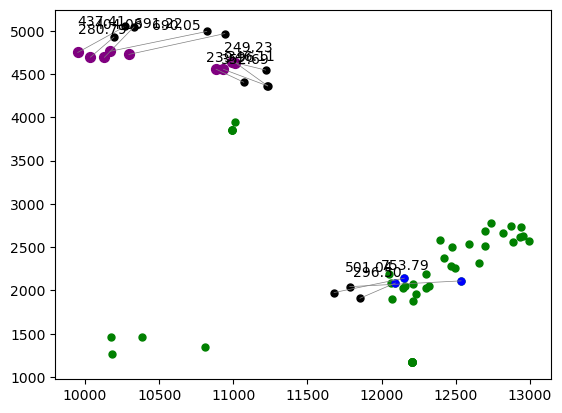

In [76]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have defined the dataframes `minions_autos` and `player_df`
# and that they have a 'time' column which you are using to associate minions with player actions.

# plt.xlim(9000, 13000)
# plt.ylim(0, 6000)

for obj_type in ["champs", "minions"]:
    if obj_type == "champs":
        print("CHAMP TIMES")
        minion_auto_times = champ_autos["time"].unique()
    else:
        print("MINIONS TIMES")
        minion_auto_times = minions_autos["time"].unique()
    minions_df = pd.read_sql(f"SELECT time, pos_x, pos_z FROM {obj_type} WHERE pos_x BETWEEN 10000 AND 14000 AND pos_z BETWEEN 0 AND 4000;", con)
    print(obj_type, minions_df.shape)

    for time in minion_auto_times:
        minions_df_row = minions_df[minions_df["time"] == time]
        if obj_type == "champs":
            print("CHAMP TIMES DATA")
            minion_auto_row = champ_autos[champ_autos["time"] == time]
        else:
            print("CHAMP TIMES DATA")
            minion_auto_row = minions_autos[minions_autos["time"] == time]
        player_row = player_df[player_df["time"] == time]
        
        if not minion_auto_row.empty and not player_row.empty:
            all_minions_x = minions_df_row["pos_x"].values
            all_minions_y = minions_df_row["pos_z"].values
            minions_autos_x = minion_auto_row["pos_x"].values[0]
            minions_autos_y = minion_auto_row["pos_z"].values[0]
            player_x = player_row["pos_x"].values[0]
            player_y = player_row["pos_z"].values[0]
            
            print(time, minions_autos_x, minions_autos_y)

            # Plot minions and players
            plt.scatter(all_minions_x, all_minions_y, c="green", s=25)
            if obj_type == "champs":
                print("PLOTTING CHAMPS")
                plt.scatter(minions_autos_x, minions_autos_y, c="purple", s=50)
            else:
                print("PLOTTING MINIONS")
                plt.scatter(minions_autos_x, minions_autos_y, c="blue", s=25)
            plt.scatter(player_x, player_y, c="black", s=25)

            # Draw a line between minion and player
            plt.plot([minions_autos_x, player_x], [minions_autos_y, player_y], c="grey", linewidth=0.5)

            # Calculate the distance
            distance = np.sqrt((minions_autos_x - player_x) ** 2 + (minions_autos_y - player_y) ** 2)
            # Annotate the distance on the line
            mid_point = ((minions_autos_x + player_x) / 2, (minions_autos_y + player_y) / 2)
            plt.annotate(f'{distance:.2f}', mid_point, textcoords="offset points", xytext=(0,10), ha='center')

    # Show the plot
plt.show()

In [77]:
replay_df = pd.merge(replay_df, all_autos_df, on="time", how="left")

In [78]:
replay_df

,time,name_0,hp_0,max_hp_0,mana_0,max_mana_0,armor_0,mr_0,ad_0,ap_0,...,using_w,ezreal_e_x_delta_digit,ezreal_e_z_delta_digit,using_e,ezreal_d_x_delta_digit,ezreal_d_z_delta_digit,using_d,target_idx,target_type,using_auto
0,15.161820,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,NaN,NaN,NaN
1,15.362079,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,NaN,NaN,NaN
2,15.629139,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,NaN,NaN,NaN
3,15.913677,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,NaN,NaN,NaN
4,16.194675,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585,178.620790,23.0,0.887174,1.000000,0.313464,0.284195,1.000000,0.280382,0.760371,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,NaN,NaN,NaN
586,178.893860,23.0,0.889506,1.000000,0.315785,0.284195,1.000000,0.280382,0.760371,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,NaN,NaN,NaN
587,179.203000,23.0,0.889506,1.000000,0.315785,0.284195,1.000000,0.280382,0.760371,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,NaN,NaN,NaN
588,179.685680,23.0,0.891825,1.000000,0.318105,0.284195,1.000000,0.280382,0.760371,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,NaN,NaN,NaN


In [79]:
replay_df["using_auto"] = replay_df["using_auto"].fillna(0)
replay_df = replay_df.fillna(0)
replay_df

,time,name_0,hp_0,max_hp_0,mana_0,max_mana_0,armor_0,mr_0,ad_0,ap_0,...,using_w,ezreal_e_x_delta_digit,ezreal_e_z_delta_digit,using_e,ezreal_d_x_delta_digit,ezreal_d_z_delta_digit,using_d,target_idx,target_type,using_auto
0,15.161820,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0
1,15.362079,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0
2,15.629139,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0
3,15.913677,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0
4,16.194675,23.0,0.889382,0.533111,0.263493,0.034960,0.790837,0.111623,0.652061,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585,178.620790,23.0,0.887174,1.000000,0.313464,0.284195,1.000000,0.280382,0.760371,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0
586,178.893860,23.0,0.889506,1.000000,0.315785,0.284195,1.000000,0.280382,0.760371,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0
587,179.203000,23.0,0.889506,1.000000,0.315785,0.284195,1.000000,0.280382,0.760371,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0
588,179.685680,23.0,0.891825,1.000000,0.318105,0.284195,1.000000,0.280382,0.760371,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0


In [80]:
# Actions
replay_df["time"] = replay_df_save_time
replay_df.iloc[:, -18:-1]

,distance_from_player_29,player_x_delta_digit,player_z_delta_digit,ezreal_q_x_delta_digit,ezreal_q_z_delta_digit,using_q,ezreal_w_x_delta_digit,ezreal_w_z_delta_digit,using_w,ezreal_e_x_delta_digit,ezreal_e_z_delta_digit,using_e,ezreal_d_x_delta_digit,ezreal_d_z_delta_digit,using_d,target_idx,target_type
0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0
1,0.0,1.0,-0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0
2,0.0,2.0,-0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0
3,0.0,2.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0
586,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0
587,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0
588,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0


In [81]:
replay_df["using_auto"].sum()

12.0

In [82]:
print("REPLAY_DF FINAL SHAPE:", replay_df.shape)

REPLAY_DF FINAL SHAPE: (590, 2268)


In [83]:
replay_df = replay_df.astype(np.float16)

In [84]:
np.save("replay", replay_df)

In [85]:
replay_df.to_csv("replay.csv")

## Get GameID

In [86]:
game_id = pd.read_sql("SELECT game_id FROM games;", con)
game_id

,game_id
0,3497271204
